# End of Night Data analyis: 2019/12/14

At the end of the night in 2019/12/14, we took a series of data without moving the hexapod at different elevations. This notebooks analyses those data set into a single place.

In [1]:
import os
import copy
import wget
import time
import asyncio
import warnings
import logging

import numpy as np
from pathlib import Path

from astropy.io import fits
from astropy.modeling import models, fitting

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter

from matplotlib import pyplot as plt

from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

plt.rcParams['figure.figsize'] = [7, 6]

%matplotlib inline

Declare where data is located and where output will be written, notably the stacked images

In [ ]:
data_folder = Path("/home/saluser/data/")
output_folder = Path("/home/saluser/data/output")

## Data set 1:

HD78955 - Az/El: 94./43. -- about 04:56 UTC

Extra-focal filename: 1576299412-HD78955-0-1.fits

Intra-focal filename: 1576299344-HD78955-0-1.fits

In [2]:
intra_fname_1 = "1576299344-HD78955-0-1.fits"
extra_fname_1 = "1576299412-HD78955-0-1.fits"

## Data set 2:

HD49258 - Az/El: 90/78 -- time 05:05:32

Extra-focal filename: 1576299960-HD49258-0-1.fits

Intra-focal filename: 1576299892-HD49258-0-1.fits

**Looks like windshake**

In [226]:
intra_fname_2 = "1576299892-HD49258-0-1.fits"
extra_fname_2 = "1576299960-HD49258-0-1.fits"

## Data set 3:

20pup el=60 time = 05:12

Extra-focal filename: 1576300283-20pup-0-1.fits

Intra-focal filename: 1576300226-20pup-0-1.fits

In [227]:
intra_fname_3 = "1576300226-20pup-0-1.fits"
extra_fname_3 = "1576300283-20pup-0-1.fits"

## Data set 4:

HD 56618 Az/El = 86/74, time = 05:15

Extra-focal filename: 1576300501-HD56618-0-1.fits

Intra-focal filename: 1576300549-HD56618-0-1.fits

In [5]:
intra_fname_4 = "1576300501-HD56618-0-1.fits"
extra_fname_4 = "1576300549-HD56618-0-1.fits"

In [236]:
# alt = np.array([44., 78., 56., 74.])
alt = np.array([44., 56., 74.])

In [134]:
class DonutHandler:
    def __init__(self):
        
        self.data_folder = Path("/home/saluser/data/")
        self.output_folder = Path("/home/saluser/data/output")

        self.intra_fnames = []
        self.extra_fnames = []
        
        self.intra_exposures = []
        self.extra_exposures = []

        # I1/I2 get modified down below, so reset here
        self.I1 = []
        self.I2 = []

        self.zern = []

        # Select where your object is, but ours will be on-axis
        self.fieldXY = [0.0,0.0]

        self.ceny = 350 #round(im_shape[0]/2)
        self.cenx = 450 # round(im_shape[1]/2)
        
        self.pre_side = 300
        self.side = 150
        
    @property
    def ndata(self):
        return len(self.intra_fnames)
    
    def set_intra_extra(self, intra, extra):
        
        self.intra_fnames = intra
        self.extra_fnames = extra
        
        for i in range(self.ndata):
            self.intra_exposures.append((fits.open(self.data_folder / intra_fnames[i]))[0].data)
            self.extra_exposures.append((fits.open(self.data_folder / extra_fnames[i]))[0].data)

    def center_and_cut_image(self, index, side=400, manual=False):
        
        intra_exp = self.intra_exposures[index]
        extra_exp = self.extra_exposures[index]

        if not manual:
            print("Automatic centering")
            im_shape=intra_exp.shape
            im_filtered = medfilt(intra_exp+extra_exp,[3,3])
            im_filtered -= int(np.median(im_filtered))
            mean = np.mean(im_filtered)
            # iter 1
            ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
            print(ceny, cenx)
            # iter 2
            intra_square = intra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                     cenx-self.pre_side:cenx+self.pre_side] 
            extra_square = extra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                     cenx-self.pre_side:cenx+self.pre_side]
            print(intra_square.shape, extra_square.shape)
            im = (intra_square+extra_square)
            im_filtered = medfilt(im,[3,3])
            im_filtered -= int(np.median(im_filtered))
            mean = np.mean(im_filtered)
            im_filtered[im_filtered < mean] = 0.
            im_filtered[im_filtered > mean] = 1.
            # iter 1
            cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
            print(cy2-self.pre_side, cx2-self.pre_side)    
            ceny += (cy2-self.pre_side)
            cenx += (cx2-self.pre_side)
        else:
            print("Manual centering")
            ceny=self.ceny #round(im_shape[0]/2)
            cenx=self.cenx # round(im_shape[1]/2)
        side=self.side # side length of image
        print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
        im_shape=intra_exp.shape
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

        return intra_square, extra_square
    
    def create_images(self):
        
        for i in range(self.ndata):
            i1, i2 = self.center_and_cut_image(i)
            self.I1.append(Image(i1, self.fieldXY, Image.INTRA))
            self.I2.append(Image(i2, self.fieldXY, Image.EXTRA))

    def run_algo(self):
        # Declare instrument
        inst=Instrument('auxtel',donut_handler.I1[0].sizeinPix) # example
        hex_to_focus_scale = 41.0
        offset=1.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
        pixelsize = 3.6e-6*4 # 4 is the binning
        # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

        print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
        print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
        print('pixelSize should be: {}'.format(pixelsize))

        #declare algorithm
        # declare algorithm - exponential solver.
        algo=Algorithm('exp', inst, 1) # example     
        
        for i in range(self.ndata):
            algo.reset(donut_handler.I1[i], donut_handler.I2[i])

            algo.runIt(inst,donut_handler.I1[i],donut_handler.I2[i],'onAxis')
            
            self.zern.append(algo.zer4UpNm[0:9])


In [228]:
intra_fnames = [intra_fname_1, intra_fname_3, intra_fname_4]
extra_fnames = [extra_fname_1, extra_fname_3, extra_fname_4]

In [229]:
donut_handler = DonutHandler()

In [230]:
donut_handler.set_intra_extra(intra_fnames, extra_fnames)

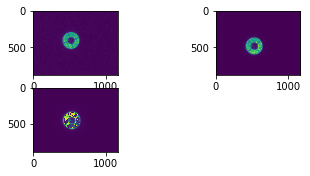

In [231]:
fig = plt.figure()

for i in range(donut_handler.ndata):
    sub = fig.add_subplot(donut_handler.ndata, 2, 1+i)
    sub.imshow(donut_handler.intra_exposures[i]+donut_handler.extra_exposures[i])


In [232]:
donut_handler.create_images()

Automatic centering
397 508
(600, 600) (600, 600)
7 10
Creating stamps of centroid [y,x] = [404,518] with a side length of 150 pixels
Automatic centering
482 521
(600, 600) (600, 600)
-2 -1
Creating stamps of centroid [y,x] = [480,520] with a side length of 150 pixels
Automatic centering
431 520
(600, 600) (600, 600)
14 9
Creating stamps of centroid [y,x] = [445,529] with a side length of 150 pixels


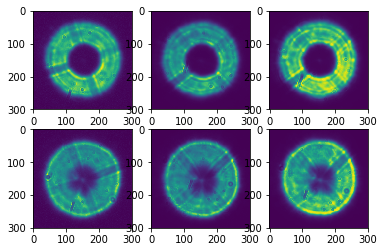

In [233]:
fig = plt.figure()

for i in range(donut_handler.ndata):
    sub1 = fig.add_subplot(2, donut_handler.ndata, 1+i)
    sub1.imshow(donut_handler.I1[i].image)

    sub2 = fig.add_subplot(2, donut_handler.ndata, donut_handler.ndata+1+i)
    sub2.imshow(donut_handler.I2[i].image)



In [234]:
donut_handler.run_algo()

Offset should be :61.5 [mm] at the focus, 1.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


Text(0, 0.5, 'Focus (nm)')

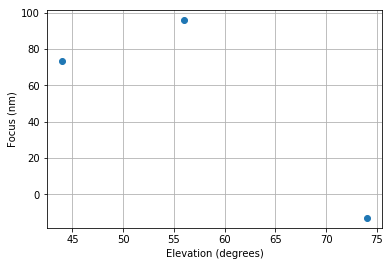

In [237]:
plt.plot(alt, np.array(donut_handler.zern).T[0], "o")
# plt.plot(alt, focus, "o")
plt.grid()
plt.xlabel("Elevation (degrees)")
plt.ylabel("Focus (nm)")

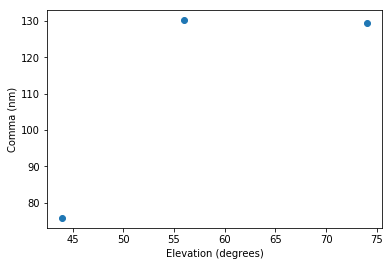

In [238]:
total_comma = np.sqrt(np.array(donut_handler.zern).T[4]**2 + 
                      np.array(donut_handler.zern).T[3]**2)
plt.plot(alt, total_comma, "o")
xlabel = plt.xlabel("Elevation (degrees)")
ylabel = plt.ylabel("Comma (nm)")

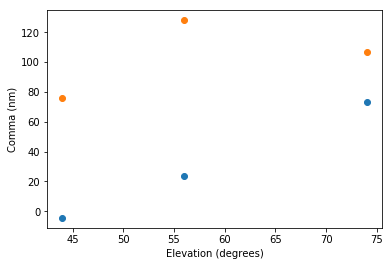

In [239]:
plt.plot(alt, np.array(donut_handler.zern).T[4], "o")
plt.plot(alt, np.array(donut_handler.zern).T[3], "o")
xlabel = plt.xlabel("Elevation (degrees)")
ylabel = plt.ylabel("Comma (nm)")

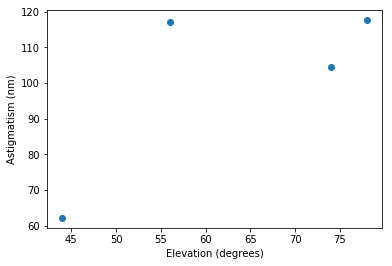

In [194]:
total_astig = np.sqrt(np.array(donut_handler.zern).T[1]**2 + 
                      np.array(donut_handler.zern).T[2]**2)
plt.plot(alt, total_astig, "o")
xlabel = plt.xlabel("Elevation (degrees)")
ylabel = plt.ylabel("Astigmatism (nm)")

In [199]:
rss = np.zeros(donut_handler.ndata)

for i in range(donut_handler.ndata):
    rss[i] = np.sqrt(np.sum((donut_handler.zern[i][1:]-donut_handler.zern[i][:-1])**2))

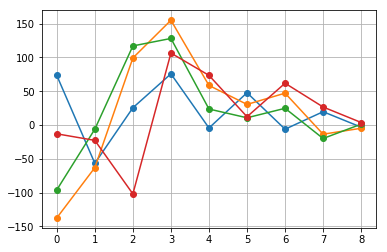

In [209]:
for i in range(donut_handler.ndata):
    plt.plot(donut_handler.zern[i], 'o-')
plt.grid()

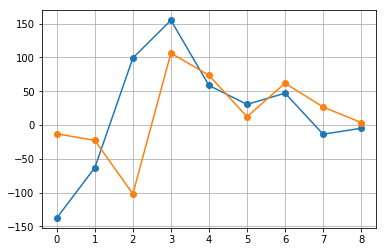

In [213]:
plt.plot(donut_handler.zern[1], 'o-')
plt.plot(donut_handler.zern[-1], 'o-')
plt.grid()

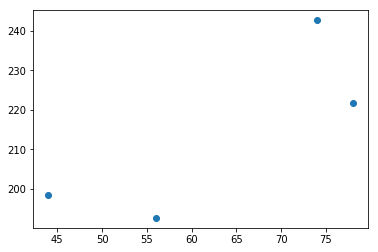

In [201]:
plt.plot(alt, rss, 'o')

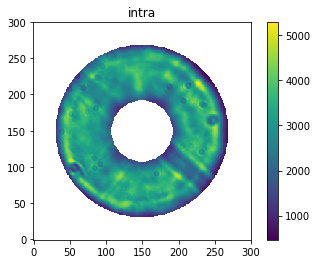

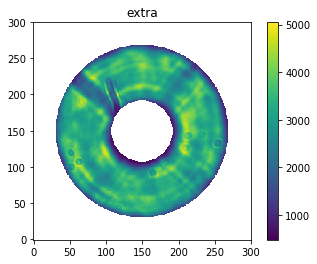

In [204]:
# Plot images with masks to check mapping is correct
# I think these plot residuals, but I1.image0 plots the original image
# plots.plotImage(donut_handler.I1[3].image0,'intra', mask=algo.pMask) 
plots.plotImage(donut_handler.I1[1].image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(donut_handler.I2[1].image,'extra', mask=algo.pMask)

In [173]:
plots.plotImage?

Signature: plots.plotImage(image, title=None, mask=None, show=True)
Docstring: <no docstring>
File:      ~/develop/cwfs/python/lsst/cwfs/plots.py
Type:      function


In [98]:
# Declare instrument
inst=Instrument('auxtel',donut_handler.I1[0].sizeinPix) # example
hex_to_focus_scale = 41.0
offset=1.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,3) # example

Offset should be :61.5 [mm] at the focus, 1.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


In [99]:
algo.runIt(inst,donut_handler.I1[0],donut_handler.I2[0],'onAxis')

resetting images: I1 and I2
itr = 0, z4-z22
[ 85. -51.  25.  96.   0.  36. -12.  16.  -4.   5.   8.  -4.   4. -18.
   4.  -3.  -3.   2. -17.]
itr = 1, z4-z22
[102. -50.  25.  97.   1.  36. -11.  16.  -3.   5.   8.  -4.   4. -19.
   4.  -3.  -2.   2. -16.]
itr = 2, z4-z22
[110. -49.  25.  96.   2.  36. -12.  17.  -4.   5.   8.  -4.   3. -18.
   4.  -3.  -3.   2. -15.]
itr = 3, z4-z22
[116. -60.  29.  98.   0.  36. -12.  17.  -3.   5.   8.  -4.   5. -19.
   4.  -3.  -2.   2. -14.]
itr = 4, z4-z22
[117. -66.  32.  95.   0.  36. -12.  17.  -3.   5.   8.  -4.   4. -18.
   4.  -3.  -2.   2. -14.]
itr = 5, z4-z22
[129. -60.  29.  70.   2.  43. -13.  19.  -3.   5.   8.  -4.   3.  -8.
   3.  -3.  -2.   1. -13.]
itr = 6, z4-z22
[137. -57.  28.  70.   2.  46. -15.  21.  -3.   5.   8.  -4.   3.  -8.
   3.  -2.  -3.   2. -13.]
itr = 7, z4-z22
[141. -57.  26.  65.  -2.  50. -16.  22.  -3.   5.   7.  -5.   5.  -6.
   3.  -2.  -2.   1. -12.]
itr = 8, z4-z22
[145. -55.  25.  69.  -0.  51. -17.  22.  -3

In [100]:
print(algo.zer4UpNm)

[ 73.33274594 -56.66559231  25.5214614   75.74078434  -4.41595962
  47.75964568  -6.21921416  19.68737663  -3.22571178   4.47093846
  12.6853749   -6.11675207   5.5107871  -10.6546038    4.16305539
  -2.25382661  -4.30068603   2.3779149  -18.96459421]


In [102]:
algo2=Algorithm('exp',inst,3) # example

In [104]:
algo2.runIt(inst,donut_handler.I1[1],donut_handler.I2[1],'onAxis')

resetting images: I1 and I2
itr = 0, z4-z22
[-134.  -52.   71.  209.   91.   27.   30.  -11.   -6.    1.    1.    7.
   -7.  -34.   -3.   -3.    5.   -5.   19.]
itr = 1, z4-z22
[-169.  -40.   95.  218.   90.   29.   27.   -9.   -8.    1.    2.    6.
   -6.  -41.   -2.   -4.    5.   -4.   16.]
itr = 2, z4-z22
[-201.  -43.  116.  229.   93.   30.   25.   -7.  -11.    2.    2.    5.
   -8.  -48.   -2.   -5.    5.   -4.   15.]
itr = 3, z4-z22
[-224.  -45.  171.  242.   92.   37.   26.   -6.  -14.    1.    2.    4.
   -8.  -55.   -1.   -6.    5.   -3.   14.]
itr = 4, z4-z22
[-248.  -60.  216.  255.   98.   43.   27.   -4.  -17.    2.    1.    4.
  -10.  -62.   -1.   -7.    5.   -2.   13.]
itr = 5, z4-z22
[-223.  -41.  168.  164.   67.   39.   36.  -14.  -10.    0.    1.    4.
    3.  -22.   -2.   -3.    5.   -4.   12.]
itr = 6, z4-z22
[-222.  -45.  144.  157.   67.   38.   41.  -16.   -7.    1.    1.    5.
    2.  -16.   -2.   -2.    5.   -4.   12.]
itr = 7, z4-z22
[-218.  -37.  132.  152. 

In [106]:
algo2.reset(donut_handler.I1[2],donut_handler.I2[2])

resetting images: I1 and I2


In [107]:
algo2.runIt(inst,donut_handler.I1[2],donut_handler.I2[2],'onAxis')

resetting images: I1 and I2
itr = 0, z4-z22
[-112.    3.   88.  161.   37.   21.   20.  -18.    0.   -3.   15.    4.
    2.  -25.   -1.   -8.    2.   -8.   22.]
itr = 1, z4-z22
[-128.    2.   89.  160.   37.   20.   19.  -19.    0.   -3.   15.    4.
    2.  -24.   -1.   -8.    2.   -8.   20.]
itr = 2, z4-z22
[-134.    3.   88.  159.   37.   21.   19.  -19.    0.   -3.   15.    4.
    3.  -23.   -1.   -8.    1.   -8.   19.]
itr = 3, z4-z22
[-141.    4.  104.  162.   36.   21.   19.  -19.    0.   -3.   15.    4.
    3.  -25.   -1.   -8.    2.   -8.   19.]
itr = 4, z4-z22
[-144.    5.  112.  163.   36.   21.   18.  -19.    1.   -3.   15.    4.
    3.  -26.   -1.   -8.    2.   -8.   18.]
itr = 5, z4-z22
[-155.   -4.  116.  129.   33.   23.   21.  -20.    0.   -2.   14.    4.
    3.  -12.   -1.   -7.    2.   -8.   17.]
itr = 6, z4-z22
[-161.   -6.  119.  123.   30.   25.   22.  -21.    0.   -2.   15.    4.
    4.  -10.   -1.   -7.    2.   -8.   16.]
itr = 7, z4-z22
[-165.   -7.  121.  122. 

In [108]:
algo3=Algorithm('exp',inst,3) # example

In [109]:
algo3.runIt(inst,donut_handler.I1[2],donut_handler.I2[2],'onAxis')

resetting images: I1 and I2
resetting images, inside
itr = 0, z4-z22
[-112.    3.   88.  161.   37.   21.   20.  -18.    0.   -3.   15.    4.
    2.  -25.   -1.   -8.    2.   -8.   22.]
itr = 1, z4-z22
[-128.    2.   89.  160.   37.   20.   19.  -19.    0.   -3.   15.    4.
    2.  -24.   -1.   -8.    2.   -8.   20.]
itr = 2, z4-z22
[-134.    3.   88.  159.   37.   21.   19.  -19.    0.   -3.   15.    4.
    3.  -23.   -1.   -8.    1.   -8.   19.]
itr = 3, z4-z22
[-141.    4.  104.  162.   36.   21.   19.  -19.    0.   -3.   15.    4.
    3.  -25.   -1.   -8.    2.   -8.   19.]
itr = 4, z4-z22
[-144.    5.  112.  163.   36.   21.   18.  -19.    1.   -3.   15.    4.
    3.  -26.   -1.   -8.    2.   -8.   18.]
itr = 5, z4-z22
[-155.   -4.  116.  129.   33.   23.   21.  -20.    0.   -2.   14.    4.
    3.  -12.   -1.   -7.    2.   -8.   17.]
itr = 6, z4-z22
[-161.   -6.  119.  123.   30.   25.   22.  -21.    0.   -2.   15.    4.
    4.  -10.   -1.   -7.    2.   -8.   16.]
itr = 7, z4-z22
